In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
%precision %.4f

from collections import namedtuple
from dateutil.relativedelta import relativedelta
from datetime import date, datetime, timedelta
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import seaborn as sns

'%.4f'

In [ ]:
# FRED CMT data
tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
tenors = [1, 2, 3, 5, 7, 10, 20, 30] # => charts scale
#tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
end_date = datetime.today() # custom datetime(YYYY,MM,DD)
start_date = end_date - relativedelta(years=1)
level = False # True for level pca and False for change pca
# scaling = False 
freq = 'D' # D/W/M

df = pd.DataFrame()
for ticker in tickers:
    reader = FredReader(ticker, start_date, end_date)
    df0 = reader.read()
    df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
df.dropna(axis = 0, inplace = True)
df.tail(3)

In [ ]:
# PCA on 

# data cleaning
df_daily = df.resample(freq).last()
df_daily.dropna(axis = 0, inplace = True)
df_daily_centered = df_daily.sub(df_daily.mean())

from sklearn.decomposition import PCA
pca_level = PCA().fit(df_daily)

              DGS1    DGS2    DGS3    DGS5    DGS7   DGS10  DGS20  DGS30
DATE                                                                    
2022-03-01 -10.000 -13.000 -15.000 -15.000 -14.000 -11.000 -6.000 -6.000
2022-03-02  15.000  19.000  20.000  18.000  16.000  14.000 13.000 13.000
2022-03-03   2.000   3.000   2.000   0.000  -1.000   0.000  0.000  0.000
2022-03-04  -3.000  -3.000  -7.000  -9.000 -12.000 -12.000 -9.000 -8.000
2022-03-07   2.000   5.000   6.000   6.000   7.000   4.000  6.000  3.000
Cumulative Exp [0.81248903 0.94717885 0.97571759 0.98572211 0.99181651 0.99540904
 0.99809396 1.        ]


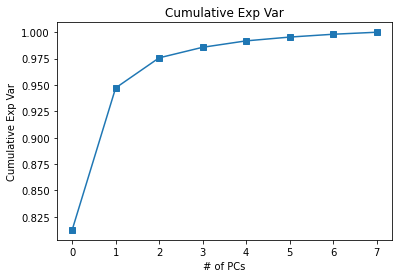

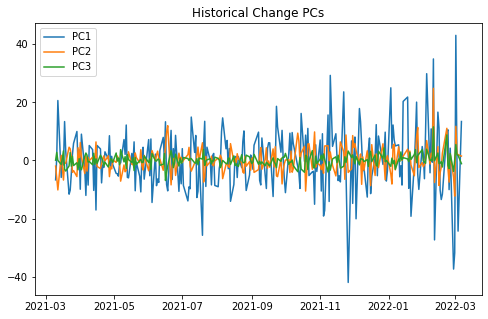

       PC_1   PC_2   PC_3
DGS1  0.162  0.361  0.718
DGS2  0.269  0.494  0.187
DGS3  0.333  0.423 -0.124
DGS5  0.402  0.195 -0.418
DGS7  0.425 -0.020 -0.299
DGS10 0.418 -0.209 -0.086
DGS20 0.376 -0.396  0.213
DGS30 0.364 -0.456  0.343


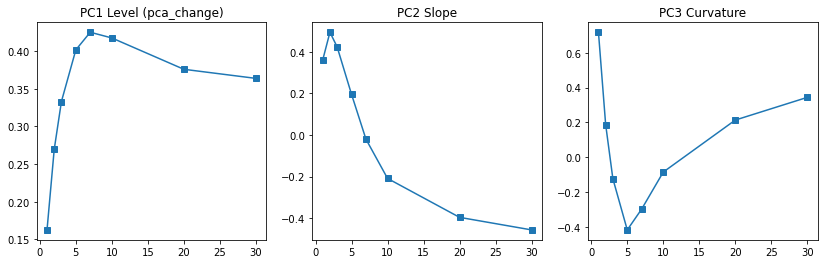

In [263]:
# PCA on Change

# data cleaning
df_daily = df.resample(freq).last()
df_daily.dropna(axis = 0, inplace = True) # remove NA rows from .resample

df_daily_diff = df_daily.diff().multiply(100) # calc change and convert into bps from %
df_daily_diff.dropna(axis = 0, inplace=True)
df_daily_diff_centered = df_daily_diff.sub(df_daily_diff.mean()) # calc de-meaned 
print(df_daily_diff.tail(5))

# run PCA
from sklearn.decomposition import PCA
pca_change = PCA().fit(df_daily_diff)

# Explained variance plot
plt.plot(pca_change.explained_variance_ratio_.cumsum(),"-s");
plt.title("Cumulative Exp Var")
plt.xlabel('# of PCs');
plt.ylabel('Cumulative Exp Var');

# top 3 PCs explain 95%+ of the variance
print("Cumulative Exp", pca_change.explained_variance_ratio_.cumsum())

df_pca_change = pca_change.transform(df_daily_diff) # score matrix
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PC_{x+1}' for x in range(df_pca_change.shape[1])])
df_pca_change.index = df_daily_diff.index

# plot historical PCs
plt.figure(figsize=(8,5))
plt.title("Historical Change PCs") 
plt.plot(df_pca_change['PC_1'], label='PC1')
plt.plot(df_pca_change['PC_2'], label='PC2')
plt.plot(df_pca_change['PC_3'], label='PC3')
plt.legend()
plt.show();

W_change = pd.DataFrame(pca_change.components_.T)
W_change.columns = [f'PC_{i+1}' for i in range(W_change.shape[1])]
W_change.index = tickers
print(W_change.iloc[:,0:3]); # loadings/weights matrix - what was plotted below

# plot the loadings vs tenor
plt.figure(figsize=(14,4)) 
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, W_change.T.iloc[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, W_change.T.iloc[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, W_change.T.iloc[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors increase, with 7y the most (0.42bps)

In [113]:
# Analytics: 

# Map dv01 risk to PC risk via W_T * nom_risk = pc_risk
tickers = ['DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
tenors = [1, 2, 3, 5, 7, 10, 20, 30]
risk_dict = {
    '1Y':0,
    '2Y':1,
    '3Y':0,
    '5Y':-2,
    '7Y':0,
    '10Y':1,
    '20Y':0,  
    '30Y':0}
nom_risk = np.fromiter(risk_dict.values(), dtype=float)
pc_risk = np.matmul(pca_change.components_[0:3,:],nom_risk)

#print(pc_risk)
print('nom_risk', pd.DataFrame(nom_risk,tenors, columns =['DV01']))
print('PC_risk', pd.DataFrame(pc_risk, ['PC1','PC2','PC3'], columns =['PC01']))



nom_risk     DV01
1    0.0
2    1.0
3    0.0
5   -2.0
7    0.0
10   1.0
20   0.0
30   0.0
PC_risk          PC01
PC1 -0.116358
PC2 -0.105428
PC3  0.937832


In [183]:
# Residual analysis: given time period and net change per tenor, show calculated PC explained/residual
exp_pcs = 3
chg_dict = { # in bps
    '1Y':7,
    '2Y':10,
    '3Y':12,
    '5Y':12,
    '7Y':15,
    '10Y':10,
    '20Y':9,  
    '30Y':6}
chg_arr = np.fromiter(chg_dict.values(), dtype=float)
chg_arr_cen = chg_arr - df_daily_diff.mean().to_numpy()
print(chg_arr_cen) # centered change in bps

# W * W_T * chg_arr_cen to project CoD to to PC123 subspace in normal coordinates
pc_score = np.matmul(pca_change.components_[0:exp_pcs,:],chg_arr_cen)
print(pc_score)

exp_bps = np.matmul(pca_change.components_.T[:,0:exp_pcs],pc_score) # exp_bps is centered
res_bps = chg_arr_cen - exp_bps # so use chg_arr_cen
d = {'CoD': chg_arr, 'Exp': exp_bps+df_daily_diff.mean().to_numpy(), 'Res': res_bps, 'check':res_bps+exp_bps+df_daily_diff.mean().to_numpy()}
print(pd.DataFrame(data=d, index = tenors)) # positive res = CoD too high vs model


[ 6.612  9.448 11.468 11.648 14.784  9.908  8.948  6.028]
[28.09699271  5.50438485 -1.06836501]
     CoD        Exp       Res  check
1    7.0   6.171728  0.828272    7.0
2   10.0  10.640436 -0.640436   10.0
3   12.0  12.351497 -0.351497   12.0
5   12.0  13.157982 -1.157982   12.0
7   15.0  12.367953  2.632047   15.0
10  10.0  10.763960 -0.763960   10.0
20   9.0   8.205525  0.794475    9.0
30   6.0   7.314903 -1.314903    6.0


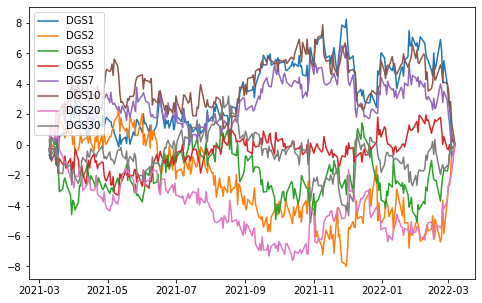

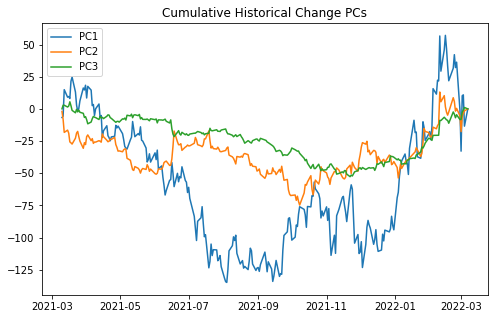

In [264]:
# application: how has each tenor's residual moved this year
# take each row of chg data, start with first row (get score, calc exp and res) then merge
pd.options.display.float_format = '{:,.3f}'.format

exp_pcs = 3

y = []

for i in range(0,len(df_daily_diff_centered.index)):
    chg_arr = df_daily_diff_centered.iloc[i,].to_numpy()
    pc_score = np.matmul(pca_change.components_[0:exp_pcs,:],chg_arr)
    exp_bps = np.matmul(pca_change.components_.T[:,0:exp_pcs],pc_score) # exp_bps is centered
    res_bps = chg_arr - exp_bps # so use chg_arr_cen
    y.append(res_bps)

df_daily_res = pd.DataFrame(y, columns = tickers, index = df_daily_diff_centered.index)
df_daily_res_sum = df_daily_res.cumsum()
df_daily_res_sum.tail(5)

plt.figure(figsize=(8,5))
plt.plot(df_daily_res_sum)
plt.legend(tickers, loc = "upper left")
plt.show()

df_pca_change_sum = df_pca_change.cumsum()
plt.figure(figsize=(8,5))
plt.title("Cumulative Historical Change PCs") 
plt.plot(df_pca_change_sum['PC_1'], label='PC1')
plt.plot(df_pca_change_sum['PC_2'], label='PC2')
plt.plot(df_pca_change_sum['PC_3'], label='PC3')
plt.legend()
plt.show();


# positive res = CoD too high vs model
#check cumulative bp residual per tenor, see how mean reverting that is...need to check why cumulative sum = 0 
#check cumulative PC3 residual, see how mean reverting that is

<Figure size 1008x288 with 0 Axes>

<AxesSubplot:title={'center':'Beta to PC1'}>

<AxesSubplot:title={'center':'Beta to PC1'}, xlabel='PC_1'>

<AxesSubplot:title={'center':'Beta to PC2'}>

<AxesSubplot:title={'center':'Beta to PC2'}, xlabel='PC_2'>

<AxesSubplot:title={'center':'Beta to PC3'}>

<AxesSubplot:title={'center':'Beta to PC3'}, xlabel='PC_3'>

0.05817894595955264 0.05271376899788269
      PC_1   PC_2   PC_3
DGS1 0.162  0.361  0.718
DGS2 0.269  0.494  0.187
DGS3 0.333  0.423 -0.124
DGS5 0.402  0.195 -0.418
DGS7 0.425 -0.020 -0.299
0.630218471415223 0.555300426769551


<Figure size 1008x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='PC_1'>

<AxesSubplot:>

<AxesSubplot:xlabel='PC_2'>

<AxesSubplot:>

<AxesSubplot:xlabel='PC_3'>

,fly55,flypca
DATE,,
2022-03-01,0.045,-0.221
2022-03-02,0.060,-0.238
2022-03-03,0.045,-0.257
2022-03-04,0.030,-0.262
2022-03-07,0.045,-0.255


<Figure size 1008x288 with 0 Axes>

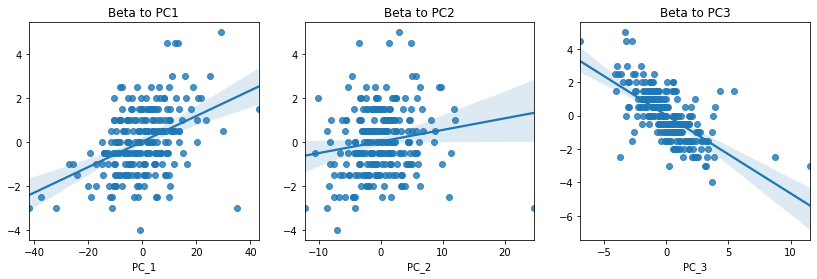

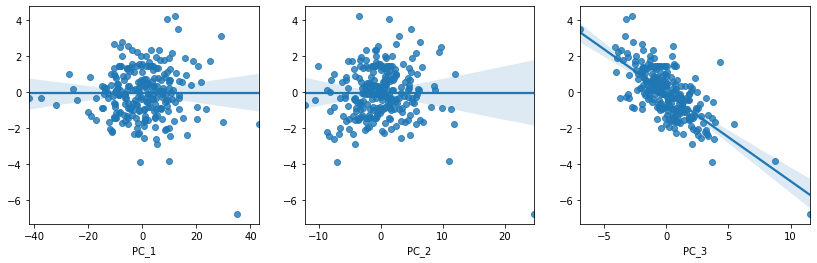

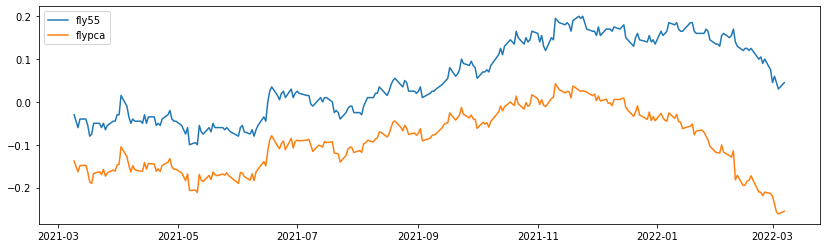

In [285]:
# Fly hedging 

fly55 = df_daily_diff['DGS5'] - (df_daily_diff['DGS2'] + df_daily_diff['DGS10'])*0.5 # easier for ratio

plt.figure(figsize=(14,4))
plt.subplot(131, title = "Beta to PC1")
sns.regplot(x=df_pca_change['PC_1'], y=fly55);
plt.subplot(132, title = "Beta to PC2")
sns.regplot(x=df_pca_change['PC_2'], y=fly55);
plt.subplot(133, title = "Beta to PC3")
sns.regplot(x=df_pca_change['PC_3'], y=fly55);

# daily changes in 2s5s10s positively correlated with PC1
# 2s5s10s higher, PC1 moves higher, duration cheaper, aligns with anectdotal evidence

W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PC_{i+1}' for i in range(W.shape[1])]
W.index = tickers

# w ij = loading of ith feature/yield of PC j

w21 = W.loc['DGS2', 'PC_1']
w22 = W.loc['DGS2', 'PC_2']
w23 = W.loc['DGS2', 'PC_3']

w51 = W.loc['DGS5', 'PC_1']
w52 = W.loc['DGS5', 'PC_2']
w53 = W.loc['DGS5', 'PC_3']

w101 = W.loc['DGS10', 'PC_1']
w102 = W.loc['DGS10', 'PC_2']
w103 = W.loc['DGS10', 'PC_3']

w551 = w51 - (w21+w101) * 0.5 # PC1 exposure of 5050 fly
w552 = w52 - (w22+w102) * 0.5 # PC1 exposure of 5050 fly
print(w551, w552)
print(W.iloc[:5,0:3]) # loading matrix

A = np.array([[w21, w101],[w22, w102]])
b = np.array([w51, w52])
w_short, w_long = np.matmul(np.linalg.inv(A), b)
print(w_short,w_long)

flypca = df_daily_diff['DGS5']*1 - (w_short*df_daily_diff['DGS2']+w_long*df_daily_diff['DGS10'])
plt.figure(figsize=(14,4))
plt.subplot(131)
sns.regplot(x=df_pca_change['PC_1'], y=flypca);
plt.subplot(132)
sns.regplot(x=df_pca_change['PC_2'], y=flypca);
plt.subplot(133)
sns.regplot(x=df_pca_change['PC_3'], y=flypca);


tsr_fly55 = df_daily['DGS5'] - (df_daily['DGS2'] + df_daily['DGS10'])*0.5
tsr_flypca = df_daily['DGS5']*1 - (w_short*df_daily['DGS2']+w_long*df_daily['DGS10'])
tsr = pd.concat([tsr_fly55, tsr_flypca], axis=1)
tsr.columns = ['fly55','flypca']

tsr.tail()

plt.figure(figsize=(14,4))
plt.plot(tsr)
plt.legend(tsr.columns, loc = "upper left")
plt.show()

In [ ]:
df_pca_level = pca_level.transform(df_daily) # transform -> score matrix; uses mean from .fit() to center but doesn't scale by s.d.
df_pca_level = pd.DataFrame(df_pca_level, columns=[f'PCA_{x+1}' for x in range(df_pca_level.shape[1])])  # output into dataframe, rename with f string
df_pca_level.index = df_daily.index

plt.figure(figsize=(8,5))
plt.title("Historical Level PCs")
plt.plot(df_pca_level['PCA_1'], label='PC1')
plt.plot(df_pca_level['PCA_2'], label='PC2')
plt.plot(df_pca_level['PCA_3'], label='PC2')  
plt.legend()
plt.show();




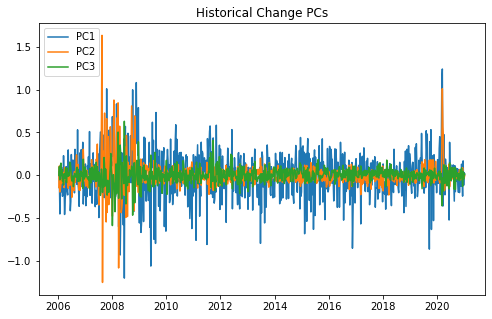

In [81]:
df_pca_change = pca_change.transform(df_daily_diff)
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PCA_{x+1}' for x in range(df_pca_change.shape[1])])
df_pca_change.index = df_daily_diff.index

plt.figure(figsize=(8,5))
plt.title("Historical Change PCs")
plt.plot(df_pca_change['PCA_1'], label='PC1')
plt.plot(df_pca_change['PCA_2'], label='PC2')
plt.plot(df_pca_change['PCA_3'], label='PC3')
plt.legend()
plt.show();

In [ ]:
# print(pca_change.singular_values_)
# print(pca_change.get_covariance())
print(pd.DataFrame(pca_change.components_.T)) # note .components_ is s.t. ith row is PCi's loading vector 

In [ ]:
# checkpoint
print(df_pca_change.iloc[:3,:3]) # show PC score / value of each PC; score = centered(df) * .components_.T
print(np.matmul(df_daily_diff_centered, pca_change.components_.T).iloc[:3, :3]) # centered(df) * .components_.T, should be same as above, ignore col names
print(np.matmul(pca_change.components_, pca_change.components_.T)[1,1]) # should both be 1 / entry from I
print(np.matmul(pca_change.components_.T, pca_change.components_)[2,2])

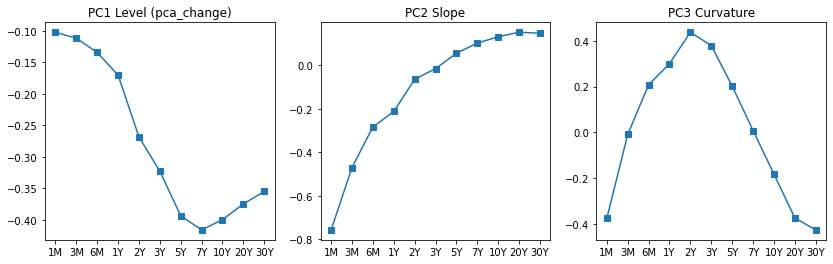

In [140]:
tenors = ['1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(14,4))
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, pca_change.components_[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, pca_change.components_[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, pca_change.components_[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors fall, 7y the most (-0.4bps)


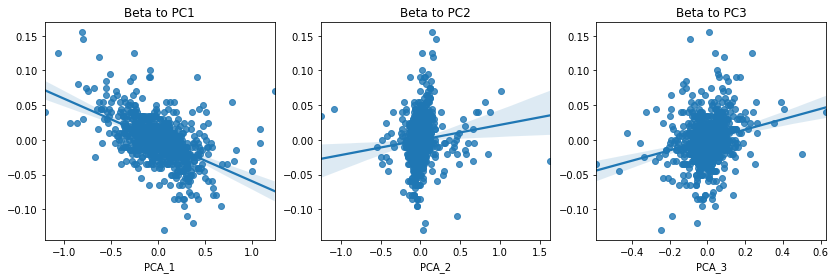

In [161]:
fly5050 = df_daily_diff['DGS5'] - (df_daily_diff['DGS2'] + df_daily_diff['DGS10'])*0.5
plt.figure(figsize=(14,4))
plt.subplot(131, title = "Beta to PC1")
sns.regplot(x=df_pca_change['PCA_1'], y=fly5050);
plt.subplot(132, title = "Beta to PC2")
sns.regplot(x=df_pca_change['PCA_2'], y=fly5050);
plt.subplot(133, title = "Beta to PC3")
sns.regplot(x=df_pca_change['PCA_3'], y=fly5050);

# 2s5s10s negatively correlated with PC1
# 2s5s10s higher, PC1 moves lower, duration cheaper; confirming tendency for 2s5s10s positive correlation with duration (cheaper => cheaper)

In [104]:
W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PC_{i+1}' for i in range(W.shape[1])]
W.index = tickers

# w ij = loading of ith feature/yield of PC j

w21 = W.loc['DGS2', 'PC_1']
w22 = W.loc['DGS2', 'PC_2']
w23 = W.loc['DGS2', 'PC_3']

w51 = W.loc['DGS5', 'PC_1']
w52 = W.loc['DGS5', 'PC_2']
w53 = W.loc['DGS5', 'PC_3']

w101 = W.loc['DGS10', 'PC_1']
w102 = W.loc['DGS10', 'PC_2']
w103 = W.loc['DGS10', 'PC_3']

w551 = w51 - (w21+w101) * 0.5 # PC1 exposure of 5050 fly
w552 = w52 - (w22+w102) * 0.5 # PC1 exposure of 5050 fly
print(w551, w552)
print(W.iloc[:5,0:3]) # loading matrix

0.05899279629925008 0.04753107215958918
          PC_1      PC_2      PC_3
DGS1  0.168187  0.359206  0.678063
DGS2  0.267204  0.500781  0.211898
DGS3  0.331504  0.429047 -0.109742
DGS5  0.401846  0.190664 -0.437021
DGS7  0.423381 -0.030804 -0.324535


In [189]:
# solve sim eq Ab = x to get PC1+2 neutral weights
A = np.array([[w21, w101],[w22, w102]])
b = np.array([w51, w52])
x,y = np.matmul(np.linalg.inv(A), b)
print(x,y)

0.4859957458180914 0.6583663710956318


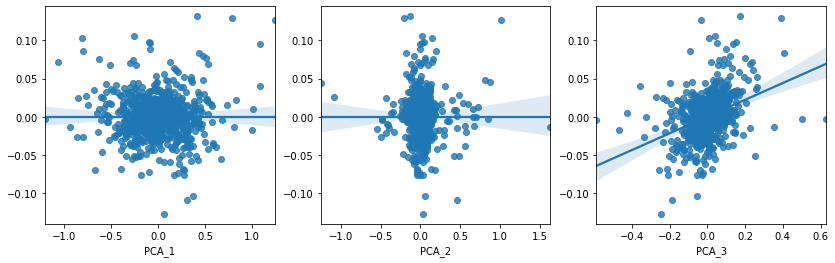

In [196]:
flypca = df_daily_diff['DGS5']*1 - (x*df_daily_diff['DGS2']+y*df_daily_diff['DGS10'])
plt.figure(figsize=(14,4))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=flypca);
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=flypca);
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=flypca);

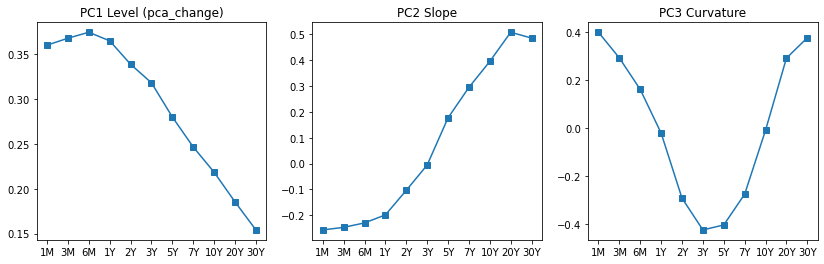

In [200]:
tenors = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(14,4))
plt.subplot(131, title = "PC1 Level (pca_change)")
plt.plot(tenors, pca_level.components_[0, :], "-s");
plt.subplot(132, title = "PC2 Slope")
plt.plot(tenors, pca_level.components_[1, :], "-s");
plt.subplot(133, title = "PC3 Curvature")
plt.plot(tenors, pca_level.components_[2, :], "-s");
# e.g. if PC1 moves by 1 unit, yields for all tenors fall, 7y the most (-0.4bps)

In [199]:
W = pd.DataFrame(pca_level.components_.T)
W.columns = [f'PCA_{i+1}' for i in range(W.shape[1])]
W.index = tickers
print(W.iloc[:5,0:3]) # loading matrix

# interpretation of pca_level loadings
# when PC1 realises, the curve is higher relative to avg with front end higher than long end

           PCA_1     PCA_2     PCA_3
DGS1MO  0.360233 -0.256559  0.399132
DGS3MO  0.367960 -0.246667  0.292259
DGS6MO  0.374633 -0.229425  0.161016
DGS1    0.365075 -0.198418 -0.020539
DGS2    0.338908 -0.103316 -0.291483


In [208]:
# mapping: nominal risk -> PC risk

nom_risk = np.array([0,0,0,0,0.48,0,-1,0,0.65,0,0])

pc_risk = np.matmul(pca_change.components_[0:3,:],nom_risk)

print(pc_risk)

[ 0.00495114 -0.00071615 -0.11061197]


In [ ]:
W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PCA_{i+1}' for i in range(W.shape[1])]
W.index = tickers

In [205]:
pca_change.components_[0:3,:]

array([[-0.10250026, -0.11200385, -0.13449477, -0.17040677, -0.26827879,
        -0.32284454, -0.39341869, -0.41581462, -0.39952882, -0.37463736,
        -0.35491257],
       [-0.75712007, -0.47010396, -0.28349481, -0.21223415, -0.06440793,
        -0.01479149,  0.05544223,  0.10253679,  0.13175675,  0.15237337,
         0.1477381 ],
       [-0.37420159, -0.00867281,  0.20771456,  0.29967192,  0.43679404,
         0.37878349,  0.20263173,  0.00858399, -0.18098674, -0.37219168,
        -0.4245789 ]])

In [78]:
E = np.matrix('0.65 -0.41 -0.06 -0.64; 0.59 -0.26 0.18 0.74; 0.44 0.73 -0.53 0.03; 0.2 0.49 0.83 -0.19')
print(E)
r_mean = np.array([[1.1],[0.7],[0.31],[0.01]])
r_net = np.array([[4.1],[5.2],[6.2],[2]])

r_c = r_net - r_mean
print(r_c)

h = np.matmul(r_c.T,E) #1x4 horiztonal vector
print(h)
r_exp = np.matmul(E[:,0:2],h.T[0:2,]) # score * PC1 laoding + score * PC2 laoding


print(r_exp)


[[ 0.65 -0.41 -0.06 -0.64]
 [ 0.59 -0.26  0.18  0.74]
 [ 0.44  0.73 -0.53  0.03]
 [ 0.2   0.49  0.83 -0.19]]
[[3.  ]
 [4.5 ]
 [5.89]
 [1.99]]
[[ 7.5946  2.8748 -0.84    1.2086]]
[[3.757822]
 [3.733366]
 [5.440228]
 [2.927572]]


In [96]:
# fly weight calculator
# residual/explained
# map nominal risk to pc risk



[[ 0.65 -0.41 -0.06 -0.64]
 [ 0.59 -0.26  0.18  0.74]
 [ 0.44  0.73 -0.53  0.03]
 [ 0.2   0.49  0.83 -0.19]]
[[ 7.3 ]
 [11.8 ]
 [ 9.71]
 [ 8.01]]
h [[17.5814  4.9522  3.188   2.8294]]
[[11.42791 ]
 [10.373026]
 [ 7.735816]
 [ 3.51628 ]]
[[-4.12791 ]
 [ 1.426974]
 [ 1.974184]
 [ 4.49372 ]]
